In [1]:
import multiprocessing
import numpy as np
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
from qiskit import Aer, execute
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [2]:
def one_step(dt, m=0.5, w=1., J=1., barrier=False):
    num_sites = system_size
    
    qc = QuantumCircuit(num_sites, num_sites)
    
    # exp(-i dt Hzz)
    for iqr in range(1, num_sites - 1):
        phi = J * 0.5 * (2. * dt) * (num_sites - iqr - 1)
        for iql in range(iqr):
            qc.cx(iql, iqr)
            qc.p(phi, iqr)
            qc.cx(iql, iqr)
            
    if barrier:
        qc.barrier()
            
    # exp(-i dt Hpm)
    # Hpm = w sum (sigma+ sigma- + h.c.) = w sum h
    # h = 1/2 XX + 1/2 YY
    phi = w * 0.5 * (2. * dt)
    for iq in range(num_sites - 1):
        # exp(-i dt w/2 XX)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        # exp(-i dt w/2 YY)
        qc.cz(iq, iq + 1)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        qc.cz(iq, iq + 1)
        
    if barrier:
        qc.barrier()

    # exp(-i dt Hz1)
    phi = m * 0.5 * (2. * dt)
    for iq in range(num_sites):
        if iq % 2 == 0:
            qc.p(-phi, iq)
        else:
            qc.p(phi, iq)
            
    if barrier:
        qc.barrier()

    # exp(-i dt Hz2)
    for iq in range(num_sites - 1):
        phi = -J * 0.5 * (num_sites // 2 - (iq + 1) // 2) * (2. * dt)
        qc.p(phi, iq)
            
    if barrier:
        qc.barrier()
            
    return qc

In [3]:
def get_subsystem_probs(circuit):
#     backend = Aer.get_backend('statevector_simulator')
#     job = execute(circuit, backend)
#     result = job.result()
#     probs = np.square(np.abs(result.data()['statevector']))
    
    backend = Aer.get_backend('qasm_simulator')
    backend.set_options(method='statevector_gpu')
    circuit.measure_all()
    shots = 2 ** 16
    job = execute(circuit, backend, shots=2**16)
    result = job.result()
    
    probs = np.zeros(2 ** system_size, dtype=np.float)
    for hexidx, count in result.data(0)['counts'].items():
        probs[int(hexidx[:(system_size // 4) + 2], 16)] = count
    probs /= shots
        
    # take the subsystem from the center of the bitstring
    margin = 2 ** ((system_size - subsystem_size) // 2)
    probs = np.sum(probs.reshape((margin, 2 ** subsystem_size, margin)), axis=(0, 2))
    
    return probs

In [4]:
def get_electron_number_distribution(probs):
    result = np.zeros(subsystem_size + 1, dtype=np.float)
    for idx, prob in enumerate(probs):
        # up to subsystem_size == 8
        bitarray = np.unpackbits(np.array(idx, dtype=np.uint8))[-1:-subsystem_size - 1:-1]
        z = np.sum(1 - bitarray[0::2], dtype=np.int) - np.sum(bitarray[1::2], dtype=np.int) + (subsystem_size // 2)
        result[z] += prob
        
    return result

In [5]:
system_size = 26
subsystem_size = 8

m = 0.5
w = 1.
J = 1.

def make_circuit(istep, dt):
    circuit = QuantumCircuit(system_size, system_size)

    # initial state = vacuum
    for iq in range(0, system_size, 2):
        circuit.x(iq)
        
    for _ in range(istep):
        circuit += one_step(dt)
        
    return circuit

dt = np.pi / 16.
num_steps = 10

def compute_probs(istep, circuit):
    return istep, get_subsystem_probs(circuit)

probs = np.empty((num_steps, 2 ** subsystem_size), dtype=np.float)
def set_prob_values(result):
    idx, probs = result
    print('got result', idx)
    probs[idx] = probs

In [6]:
#workers = multiprocessing.Pool(32)

for istep in range(num_steps):
    circuit = make_circuit(istep + 1, dt)

#     workers.apply_async(compute_probs, args=(istep, circuit), callback=set_prob_values)
    probs[istep] = get_subsystem_probs(circuit)

#workers.close()
#workers.join()

entropies = np.empty(num_steps + 1, dtype=np.float)
entropies[0] = 0.

logp = np.zeros_like(probs)
np.log2(probs, out=logp, where=(probs > 1.e-9))
entropies[1:] = -np.sum(probs * logp, axis=1)

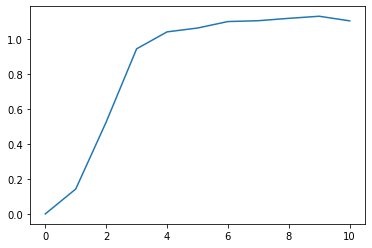

In [7]:
plt.plot(np.arange(num_steps + 1), entropies / 6.)

In [8]:
dist = get_electron_number_distribution(probs[-1])

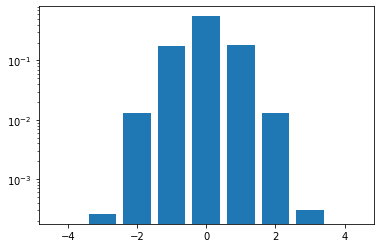

In [9]:
plt.bar(np.linspace(-(subsystem_size // 2), subsystem_size // 2, subsystem_size + 1), dist)
plt.yscale('log')